# Home assignment 1

### Deadline: 4th December, 2024 at 23:59 CET

### Name: John Klein, Kristian Rehn
### Student No.: 10044346, 10043938

In this assignment we go through the following topics:
- Making a Data set class that inherits from `torch.utils.data.Dataset`
- Data Augmentation
- Transfer Learning or Fine Tuning
- Making a function for training

We are going to implement an image segmentation model for a pet dataset. We will use a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

### Image Segmentation

In an image segmentation task, a class is assigned to each pixel of the image.

Image segmentation is typically used to locate objects and boundaries in images and has many applications in medical imaging, self-driving cars and satellite imaging, for example.


This tutorial uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al, 2012). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

   * Class 1: Pixel belonging to the pet.
   * Class 2: Pixel bordering the pet.
   * Class 3: None of the above/a surrounding pixel.

### Setup


In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import (
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNNPredictor,
)
from torchvision.transforms import functional

# Define a directory where you want to store the dataset
# We recommend using Colab, if you do not have a GPU!
colab_dir = "./testing/ColabNotebooks/"  # Update this with your directory

# Load the dataset using the updated paths
pets_path_train = os.path.join(colab_dir, "OxfordPets", "train")
pets_path_test = os.path.join(colab_dir, "OxfordPets", "test")


### Define Datasets
The dataset consists of `(image, mask)` tuples. The image is a standard RGB PIL image. The masks are a single-channel PIL image where each pixel is one of the three category label values (0, 1 or 2).
PIL images can be transformed to Tensors using [torchvision.transforms.functional.pil_to_tensor](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.pil_to_tensor) or vice-versa with [torchvision.transforms.functional.to_pil_image](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.functional.to_pil_image).

In [ ]:
# Define the dataset and test dataset
dataset = torchvision.datasets.OxfordIIITPet(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=True,
)
dataset_test = torchvision.datasets.OxfordIIITPet(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=True,
)

100%|██████████| 792M/792M [00:28<00:00, 27.6MB/s]


Extracting testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet/images.tar.gz to testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 11.3MB/s]


Extracting testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to testing/ColabNotebooks/OxfordPets/train/oxford-iiit-pet


100%|██████████| 792M/792M [00:29<00:00, 27.1MB/s]


Extracting testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet/images.tar.gz to testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 9.30MB/s]


Extracting testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to testing/ColabNotebooks/OxfordPets/test/oxford-iiit-pet


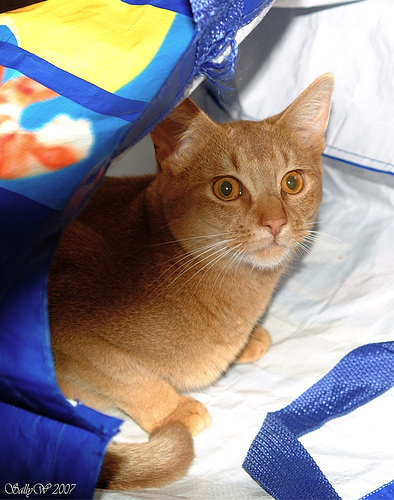

In [ ]:
image, mask = dataset[0]
# Show one image
image

In [ ]:
# Print the mask Tensor
mask_tensor = functional.pil_to_tensor(mask)
mask_tensor

tensor([[[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]], dtype=torch.uint8)

### Define transforms

These transforms augment the training data to improve the robustness of the model.
Use at least 3 different transforms for augmenting the data.
The transforms should augment the image, e.g., distort, crop or rotate.
Transforms that only convert the image to Tensors do not count as augmentation.

See https://pytorch.org/vision/0.11/transforms.html for a list of all transforms.


In [ ]:
data_transforms = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.NEAREST),  #NEAREST to prevent interpolating, keep only 0,1,(2?)
    transforms.ToTensor()
    ]
)


### Define Collate Functions and Dataloaders
Notes:
- You do not have to use collate functions. However they are an easy way to apply methods to and order the data. The data is given as a list of `(image, mask)` tuples, but depending on your implementation, it may be beneficial to load the batches as a tuple of lists, i.e., `([images], [masks])`. The required reordering can be achieved using a collate function.
- Apply the above transforms to the training data. Keep in mind, you should apply the same transforms to the image and mask.
- The model requires a binary mask. Set all pixels that are not the pet in the image to 0.
- You should use a separate collate function for the train and test set. The test set does not need to be transformed, but converted to tensors.

In [ ]:
import random
# Collate function for the train set
def collate_train(batch):
    images, masks = [], []
    for image, mask in batch:
        # Seed the random generator
        seed = random.randint(0, 2**32)

        # Apply transforms to the image
        torch.manual_seed(seed)
        transformed_image = data_transforms(image)
        transformed_image = functional.to_pil_image(transformed_image)


        # Apply the same transforms to the mask
        torch.manual_seed(seed)
        mask_tensor = functional.pil_to_tensor(mask)
        mask_tensor[mask_tensor != 1] = 0
        mask = functional.to_pil_image(mask_tensor)
        transformed_mask = data_transforms(mask)
        transformed_mask = transformed_mask*255




        transformed_mask[transformed_mask != 1] = 0
        transformed_mask = functional.to_pil_image(transformed_mask)



        images.append(transformed_image)
        masks.append(transformed_mask)
    return images,masks


# Collate function for the test set
def collate_test(batch):
    pass


# Create data loaders for training and testing (using DIFFERENT collate functions!)
# Feel free to use custom hyperparameters
batch_size = 4
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_train,
)
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_test
)

### Example images
To check that the masks and transforms are calculated correctly, plot four images, their masks, the transformed version and the corresponding mask.

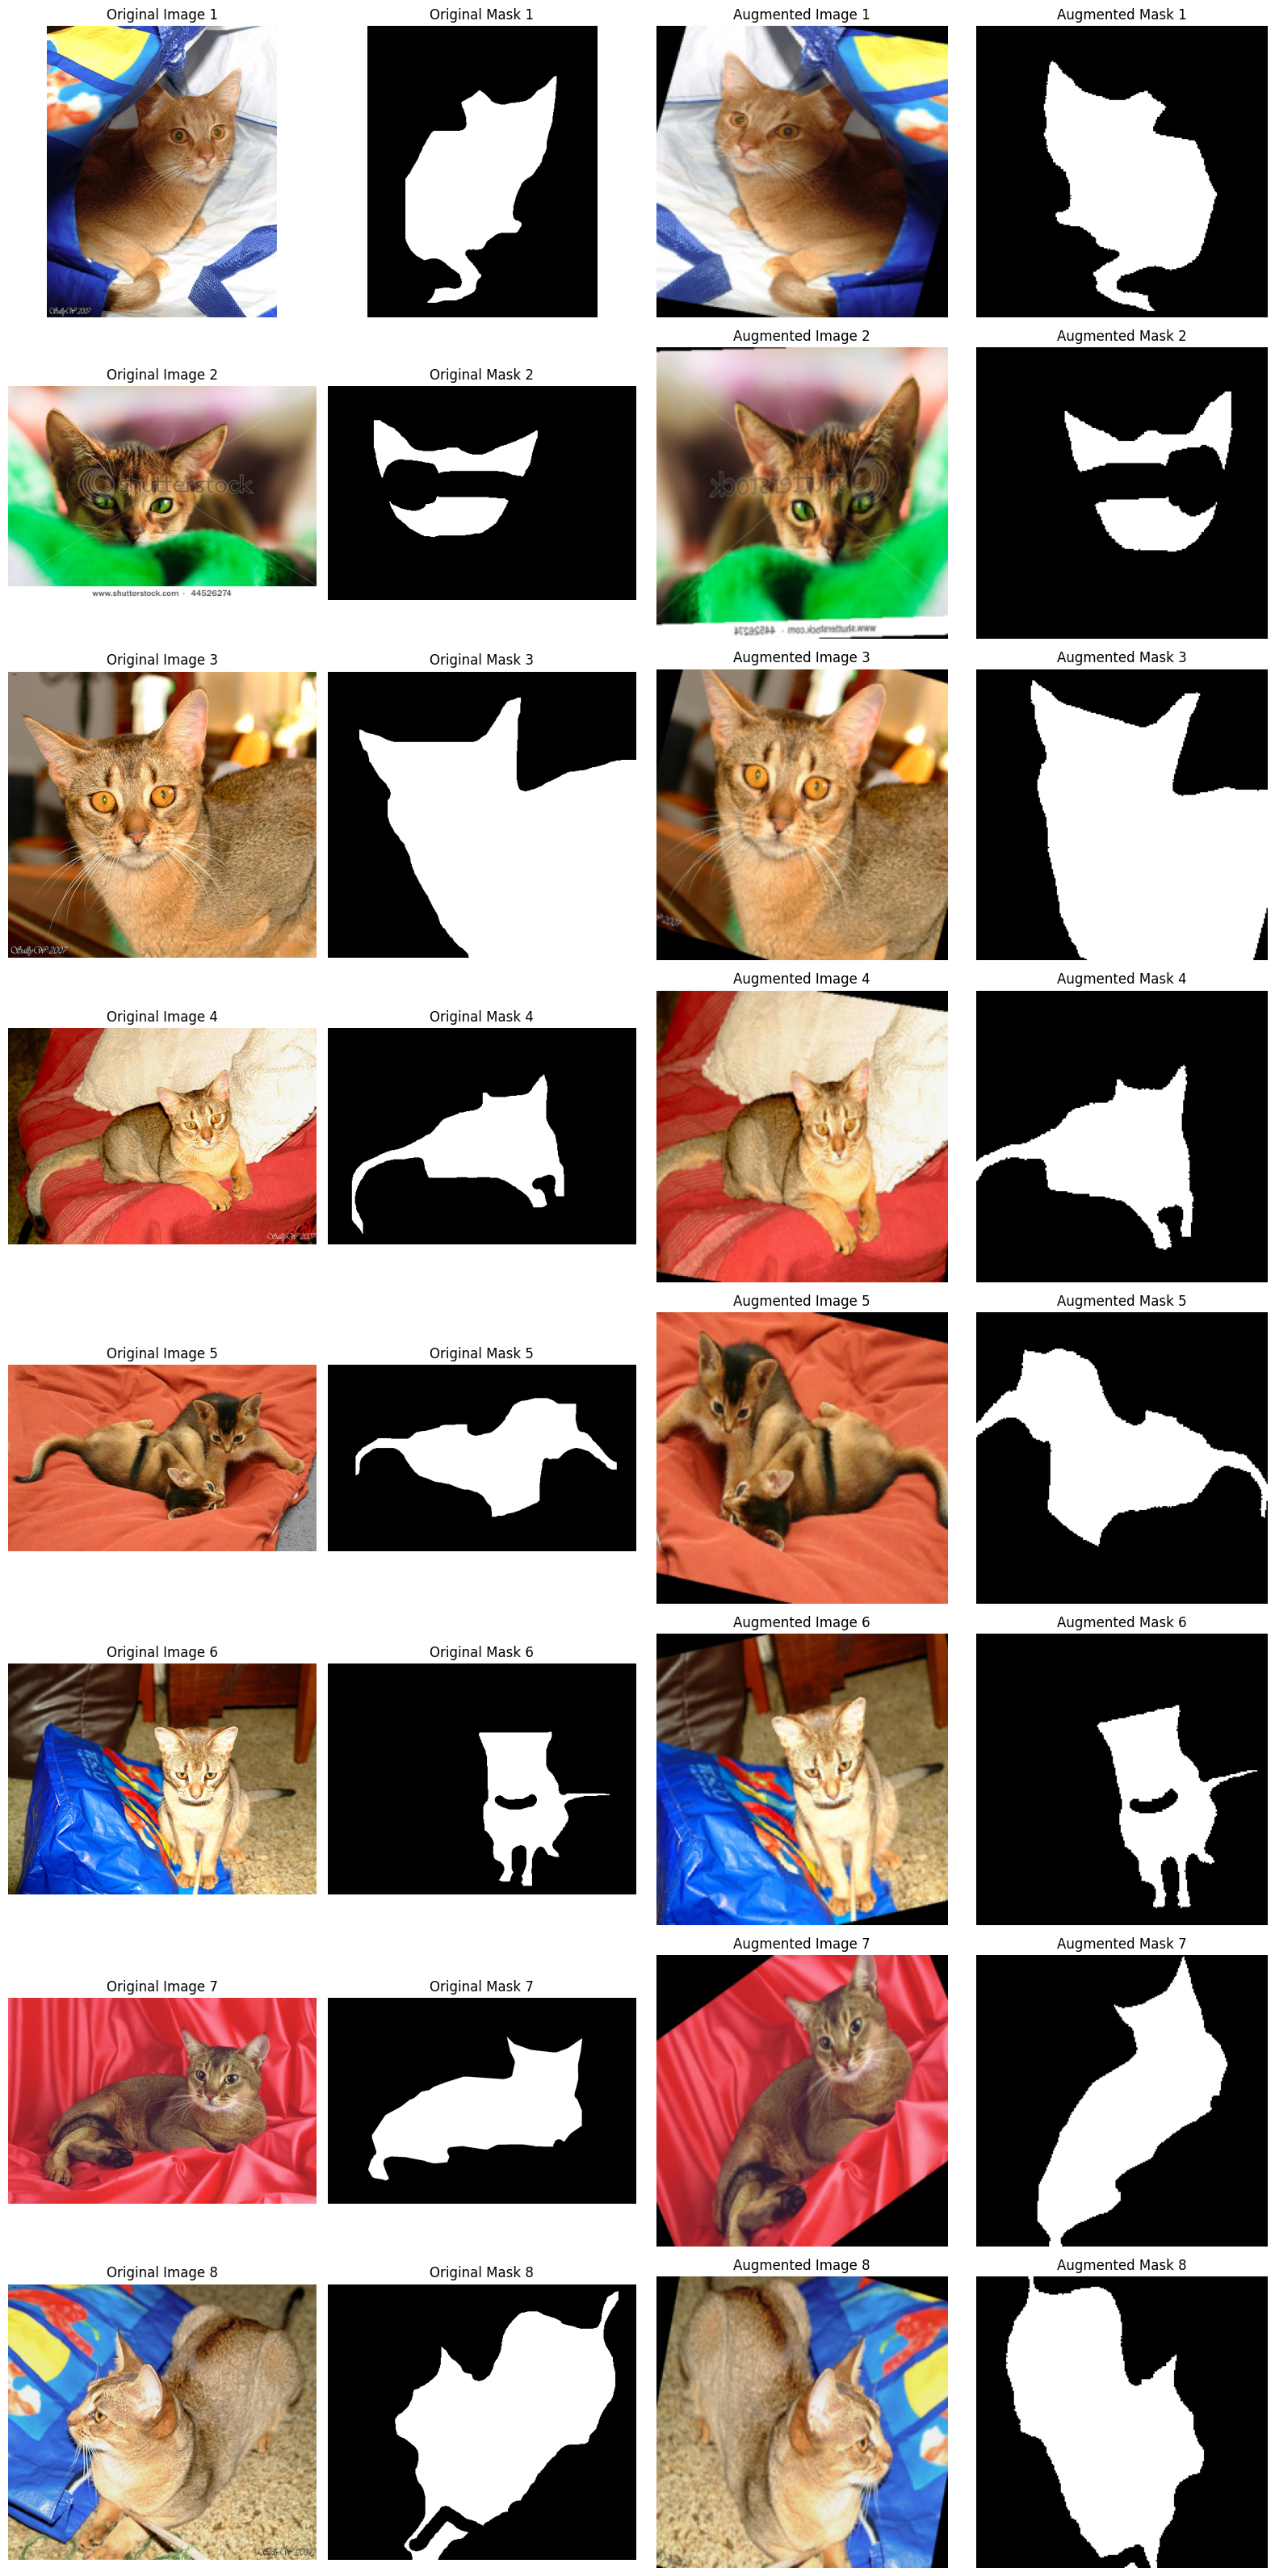

In [ ]:
# Visualize original and augmented versions of four images
for images, masks in data_loader:
    fig, axs = plt.subplots(batch_size, 4, figsize=(16, batch_size * 4))
    for j in range(batch_size):
        # Original Image and Mask
        original_image, original_mask = dataset[j]  # Fetch original image and mask

        mask_tensor = functional.pil_to_tensor(original_mask)
        mask_tensor[mask_tensor != 1] = 0
        original_mask = functional.to_pil_image(mask_tensor)

        # Augmented Image and Mask
        augmented_image = images[j]  # Convert Tensor to NumPy
        augmented_mask = masks[j] # Squeeze the mask for 2D visualization


        # Plot original image
        axs[j, 0].imshow(original_image)
        axs[j, 0].set_title(f"Original Image {j + 1}")
        axs[j, 0].axis('off')

        # Plot original mask
        axs[j, 1].imshow(original_mask, cmap='grey')
        axs[j, 1].set_title(f"Original Mask {j + 1}")
        axs[j, 1].axis('off')

        # Plot augmented image
        axs[j, 2].imshow(augmented_image)
        axs[j, 2].set_title(f"Augmented Image {j + 1}")
        axs[j, 2].axis('off')

        # Plot augmented mask
        axs[j, 3].imshow(augmented_mask, cmap='grey')
        axs[j, 3].set_title(f"Augmented Mask {j + 1}")
        axs[j, 3].axis('off')

    plt.tight_layout()
    plt.show()
    break  # Visualize one batch only

### Introduction to transfer learning


* Transfer learning is an ML methods to **reuse a pre-trained model** on a new problem by exploiting the knowledge gained from a previous task to improve generalization about another similar task.
* Steps:
  1. Select a pre-trained source model
  2. Adapt the source model to create the target model
  3. Fine-tuning: Train source model to achieve the target model
* Strategies for fine-tuning of model:
* There are different **strategies for fine-tuning** the model: You can train the entire model or only some layers and leave the others frozen. Usually, if you have a small dataset and a large number of parameters, you will leave more layers frozen to avoid overfitting. By contrast, if the dataset is large and the number of parameters is small, you can improve your model by training more layers to the new task since overfitting is not an issue.
* **Main benefits:** less training data needed, better initial model, higher learning rate, faster training, higher accuracy after training
* **Example:** In training a classifier to predict the animal species, you could use the knowledge it gained during training to recognize dog breeds.


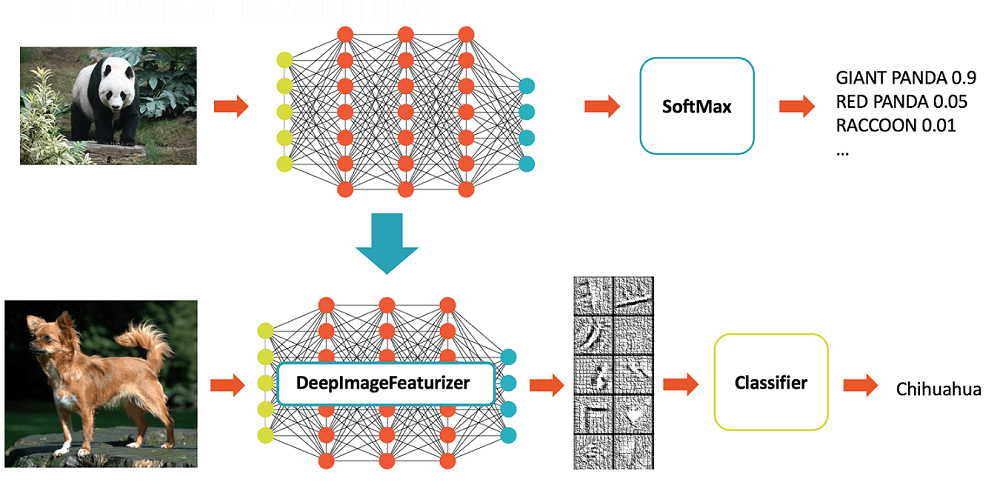

### Defining model and Prediction

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

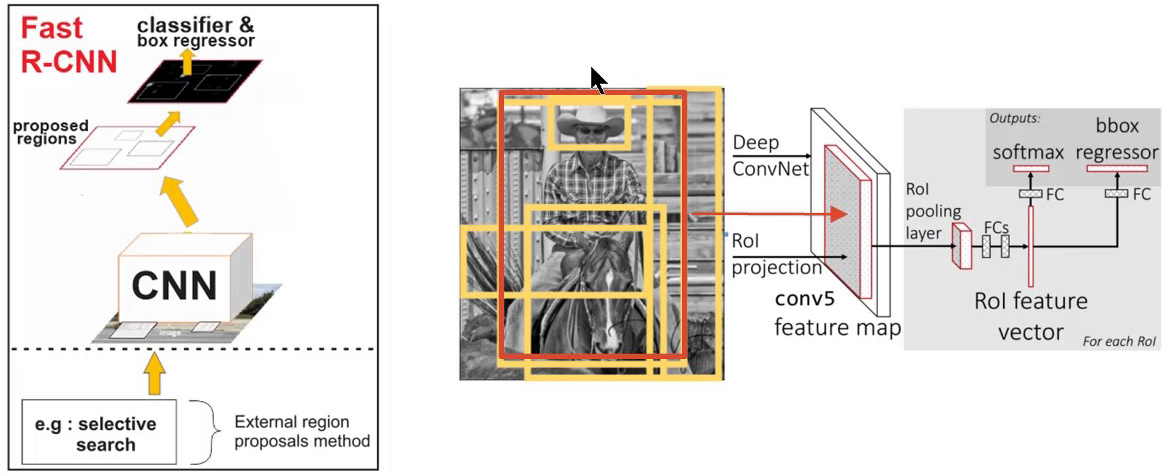


Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

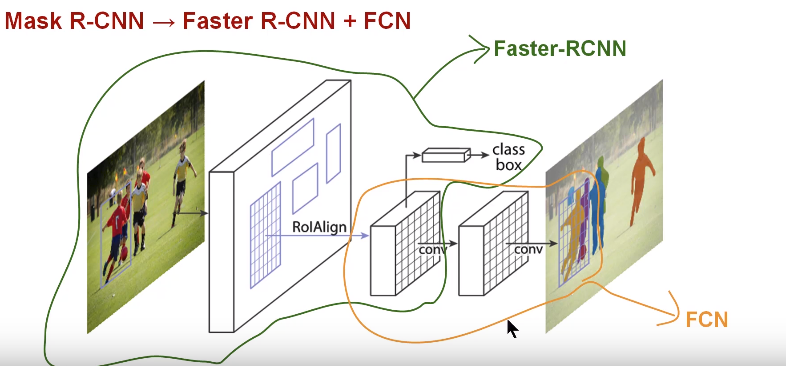





One of popular ways to modify models in torchvision modelzoo when we want to use a pre-trained model, and just finetune the last layer is transfer learning. In our task we want to also compute the segmentation masks, so we will be using Mask R-CNN.

### Define some hyperparameters:
Feel free to test some other options

In [ ]:
NUM_CLASSES = 3
HIDDEN_LAYER = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

This part initializes the model, optimizer and learning rate scheduler.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Model Setup:
# Load a pre-trained Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)

# Get the number of input features for the classifier and replace the head for the box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the head for the box predictor with FastRCNNPredictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

# Get the number of input features for the mask classifier and replace the mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# Replace the mask predictor with MaskRCNNPredictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, HIDDEN_LAYER, NUM_CLASSES
)

# Move the model to the appropriate device
model.to(device)


# Optimizer and Learning Rate Scheduler:
# Create an optimizer with proper lr, momentum, and weight decay
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001
)

# Create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 150MB/s]


Some notes that may or may not be applicable to you:
- You may have to check if a bounding box is valid (i.e., contains foreground and is not 0-width or 0-height)
- Filter out all masks that have invalid bounding boxes

Now, let’s make a function for training each epoch:

In [ ]:
data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


def get_boxes(mask):
    pos = mask.squeeze().nonzero()
    if pos.numel() == 0:  # If there are no foreground pixels
        return torch.empty((0, 4), dtype=torch.int64)  # Return an empty tensor
    boxes = torch.as_tensor(
        [
            torch.min(pos[:, 1]),
            torch.min(pos[:, 0]),
            torch.max(pos[:, 1]),
            torch.max(pos[:, 0]),
        ],
        dtype=torch.int64,
    ).unsqueeze(0)
    return boxes

def train(model, optimizer, dataloader, device, epoch, lr_scheduler=None, print_freq=10):
    """
    Train function for the Mask R-CNN model.

    Parameters:
    - model: Mask R-CNN model
    - optimizer: Optimizer instance
    - dataloader: Dataloader providing batches of images and masks
    - device: Computation device ('cpu' or 'cuda')
    - epoch: Current epoch number
    - num_epochs: Total number of epochs
    - lr_scheduler: Learning rate scheduler (optional)
    - print_freq: Print frequency for loss updates
    """
    model.train()  # Set the model to training mode
    total_loss = 0.0  # For tracking total loss across batches

    for batch_idx, (images, masks) in enumerate(dataloader):
        # Convert images and masks to tensors and send to device
        images = [data_transforms(image).to(device) for image in images]
        masks = [data_transforms(mask).to(device) for mask in masks]

        # Prepare targets for the model
        targets = [
            {
                "boxes": get_boxes(masks[i]).to(device),
                "labels": torch.ones(1, dtype=torch.int64).to(device),  # One label per mask
                "masks": masks[i],
                "image_id": i,
            }
            for i in range(len(images))
        ]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: calculate losses
        loss_dict = model(images, targets)  # Outputs a dictionary of losses
        loss = sum(loss for loss in loss_dict.values())  # Combine all losses

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate and print batch loss
        total_loss += loss.item()
        if batch_idx % print_freq == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], "
                f"Loss: {loss.item():.4f}"
            )

    # Average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {average_loss:.4f}")

    # Step the learning rate scheduler if provided
    if lr_scheduler is not None:
        lr_scheduler.step()

    return average_loss


And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# Update the number of epochs
num_epochs = 10

# TODO: Update the dataloader *if needed*

# Call the train function
for epoch in range(num_epochs):
    print(epoch)
    train(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()


0
Epoch [0/10], Batch [0/920], Loss: 0.2764
Epoch [0/10], Batch [10/920], Loss: 0.1549
Epoch [0/10], Batch [20/920], Loss: 0.2079
Epoch [0/10], Batch [30/920], Loss: 0.2394
Epoch [0/10], Batch [40/920], Loss: 0.3327
Epoch [0/10], Batch [50/920], Loss: 0.2104
Epoch [0/10], Batch [60/920], Loss: 0.3671
Epoch [0/10], Batch [70/920], Loss: 0.1979
Epoch [0/10], Batch [80/920], Loss: 0.1210
Epoch [0/10], Batch [90/920], Loss: 0.1681
Epoch [0/10], Batch [100/920], Loss: 0.1408
Epoch [0/10], Batch [110/920], Loss: 0.2568
Epoch [0/10], Batch [120/920], Loss: 0.1822
Epoch [0/10], Batch [130/920], Loss: 0.2501
Epoch [0/10], Batch [140/920], Loss: 0.2521
Epoch [0/10], Batch [150/920], Loss: 0.2512
Epoch [0/10], Batch [160/920], Loss: 0.2325
Epoch [0/10], Batch [170/920], Loss: 0.2118
Epoch [0/10], Batch [180/920], Loss: 0.1897
Epoch [0/10], Batch [190/920], Loss: 0.1692
Epoch [0/10], Batch [200/920], Loss: 0.1776
Epoch [0/10], Batch [210/920], Loss: 0.1542
Epoch [0/10], Batch [220/920], Loss: 0.27

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), '/content/Model/model_1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.
### Training and evaluation:


### Prediction:
Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# Pick one image from the test set
img, _ = dataset_test[0]

# Put the model in evaluation mode
model.eval()

# TODO: Continue the code to make predictions with the model


Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed.

In [ ]:
prediction

Let's inspect and visualize the image and the top predicted segmentation masks.


In [ ]:
# TODO

And let's now visualize the top predicted segmentation mask.

In [ ]:
# TODO

For some other examples visualize original image and all predicted segmentation masks.

In [ ]:
# TODO

### Evaluation
In semantic segmentation tasks, you want to assess the quality of pixel-wise predictions made by your model. This includes metrics like Intersection over Union (IoU), Dice Coefficient, and Pixel Accuracy.

We recommend using [torchmetrics](https://torchmetrics.readthedocs.io/en/v0.9.3/).

In [ ]:
# TODO: Evaluate your model and compute relevant semantic segmentation metrics
# 1. Calculate and print the Intersection over Union (IoU) for each class and the mean IoU.
# 2. Calculate and print the Dice Coefficient for each class and the mean Dice Coefficient.
# 3. Compute and print the Pixel Accuracy.


# Exercise 2: Recurrent Neural Networks
In this task, you will use Recurrent Neural Networks to classify gyroscopic sensor data3 into one
of six human activities (walking/sitting/standing/...). We will provide preprocessed tensor-data
for this task. For this task, you are free in your choice of frameworks and libraries as long as
you:

- Load the data and explore it: At least print the shape and write down the meaning of each
dimension
- Use an RNN with at least one hidden layer.
- Train the RNN for at least 5 epochs on the human activities dataset using a suitable loss
function.
- Perform validation after each epoch.
- Compute the final test accuracy for your best model checkpoint (selected via validation
performance). A suitable classifier should achieve >80% accuracy on the test set.

In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import (
    MaskRCNN_ResNet50_FPN_Weights,
    MaskRCNNPredictor,
)
from torchvision.transforms import functional
import os.path
from os import path

# Define a directory where you want to store the dataset
# We recommend using Colab, if you do not have a GPU!

if path.exists('./testing/') == False:
  os.mkdir('./testing/')

if path.exists('./testing/ColabNotebooks/') == False:
  os.mkdir('./testing/ColabNotebooks/')

if path.exists('./testing/ColabNotebooks/HAR') == False:
  os.mkdir('./testing/ColabNotebooks/HAR')

colab_dir = "./testing/ColabNotebooks/"  # Update this with your directory

from torch.utils.data import Dataset
from tqdm import tqdm

In [6]:
# first load datasets

har_test_data = torch.load(os.path.join(colab_dir, "HAR", "test.pt"))
har_train_data = torch.load(os.path.join(colab_dir, "HAR", "train.pt"))

class HAR(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data["samples"][:,:,:128].permute(0, 2, 1)
        self.labels = data["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

har_test = HAR(har_test_data)
har_train = HAR(har_train_data)

#Setup device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


<ipython-input-6-cc998640e39e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  har_test_data = torch.load(os.path.join(colab_dir, "HAR", "test.pt"))
<ipython-input-6-cc9986

In [7]:
# explore dataset
print(f"length of train data: {len(har_train)}")
print(f"length of test data: {len(har_test)}\n")

print(f"shape of gyro data: {tuple(har_train[0][0].shape)}")
print(har_train[0][0])

length of train data: 5881
length of test data: 2947

shape of gyro data: (128, 3)
tensor([[0.1904, 0.7879, 0.5734],
        [0.1911, 0.7872, 0.5699],
        [0.1900, 0.7876, 0.5712],
        [0.1898, 0.7875, 0.5731],
        [0.1899, 0.7873, 0.5748],
        [0.1883, 0.7866, 0.5755],
        [0.1886, 0.7859, 0.5749],
        [0.1879, 0.7860, 0.5748],
        [0.1831, 0.7864, 0.5747],
        [0.1819, 0.7873, 0.5720],
        [0.1864, 0.7895, 0.5691],
        [0.1916, 0.7911, 0.5698],
        [0.1912, 0.7900, 0.5733],
        [0.1899, 0.7890, 0.5751],
        [0.1929, 0.7884, 0.5698],
        [0.1927, 0.7860, 0.5667],
        [0.1926, 0.7842, 0.5780],
        [0.1940, 0.7857, 0.5894],
        [0.1917, 0.7886, 0.5829],
        [0.1890, 0.7894, 0.5732],
        [0.1841, 0.7887, 0.5715],
        [0.1821, 0.7889, 0.5691],
        [0.1870, 0.7890, 0.5666],
        [0.1884, 0.7888, 0.5648],
        [0.1876, 0.7893, 0.5648],
        [0.1893, 0.7906, 0.5692],
        [0.1908, 0.7923, 0.5697],

Each sample is a time series consisting of 3 dimensions captured at a constant rate of 50hz:
1. 3-axial gravitational acceleration
2. 3-axial body motion component acceleration
3. 3-axial angular velocity

With a label according to one of the following activities: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

Now plot one sample:

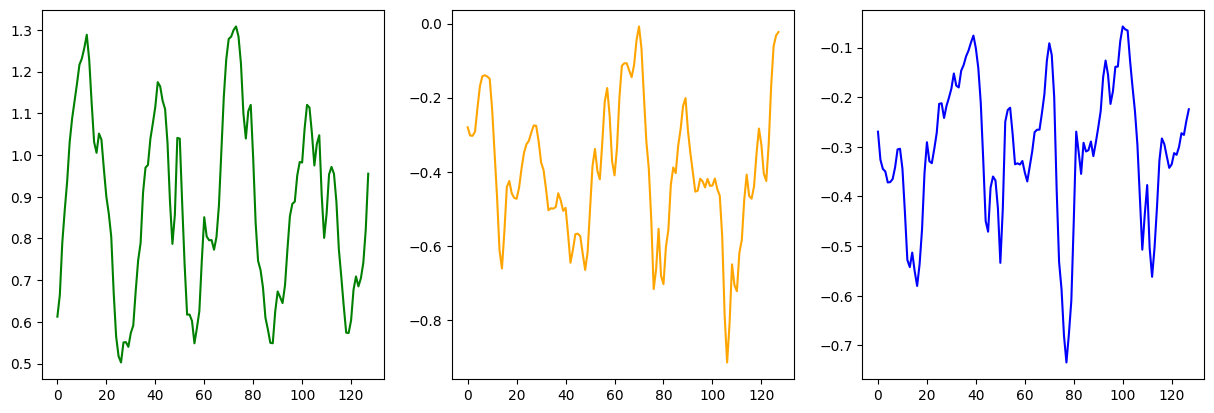

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, )
fig.set_figwidth(15)

X = np.arange(128)
for i, t in enumerate(har_train[1][0].T):
    ax[i].plot(X, t, color=["green", "orange", "blue"][i])

In [9]:
batch_size = 4
har_loader = DataLoader(
    har_train,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)
har_loader_test = DataLoader(
    har_test,
    batch_size=1,
    shuffle=False,
    num_workers=2,
)

In [10]:
for X, y in har_loader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([4, 128, 3])
Shape of y: torch.Size([4]) torch.float64


In [11]:
print(f"First 2 samples of X:\n {X[:2]}")
print(f"First 2 samples of y:\n {y[:2]}")

First 2 samples of X:
 tensor([[[ 0.1904,  0.7879,  0.5734],
         [ 0.1911,  0.7872,  0.5699],
         [ 0.1900,  0.7876,  0.5712],
         [ 0.1898,  0.7875,  0.5731],
         [ 0.1899,  0.7873,  0.5748],
         [ 0.1883,  0.7866,  0.5755],
         [ 0.1886,  0.7859,  0.5749],
         [ 0.1879,  0.7860,  0.5748],
         [ 0.1831,  0.7864,  0.5747],
         [ 0.1819,  0.7873,  0.5720],
         [ 0.1864,  0.7895,  0.5691],
         [ 0.1916,  0.7911,  0.5698],
         [ 0.1912,  0.7900,  0.5733],
         [ 0.1899,  0.7890,  0.5751],
         [ 0.1929,  0.7884,  0.5698],
         [ 0.1927,  0.7860,  0.5667],
         [ 0.1926,  0.7842,  0.5780],
         [ 0.1940,  0.7857,  0.5894],
         [ 0.1917,  0.7886,  0.5829],
         [ 0.1890,  0.7894,  0.5732],
         [ 0.1841,  0.7887,  0.5715],
         [ 0.1821,  0.7889,  0.5691],
         [ 0.1870,  0.7890,  0.5666],
         [ 0.1884,  0.7888,  0.5648],
         [ 0.1876,  0.7893,  0.5648],
         [ 0.1893,  0.7906,

In [12]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")
print(f"Type for one sample of X: {type(X_sample)} and the same for y: {type(y_sample)}")

Values for one sample of X: tensor([[0.1904, 0.7879, 0.5734],
        [0.1911, 0.7872, 0.5699],
        [0.1900, 0.7876, 0.5712],
        [0.1898, 0.7875, 0.5731],
        [0.1899, 0.7873, 0.5748],
        [0.1883, 0.7866, 0.5755],
        [0.1886, 0.7859, 0.5749],
        [0.1879, 0.7860, 0.5748],
        [0.1831, 0.7864, 0.5747],
        [0.1819, 0.7873, 0.5720],
        [0.1864, 0.7895, 0.5691],
        [0.1916, 0.7911, 0.5698],
        [0.1912, 0.7900, 0.5733],
        [0.1899, 0.7890, 0.5751],
        [0.1929, 0.7884, 0.5698],
        [0.1927, 0.7860, 0.5667],
        [0.1926, 0.7842, 0.5780],
        [0.1940, 0.7857, 0.5894],
        [0.1917, 0.7886, 0.5829],
        [0.1890, 0.7894, 0.5732],
        [0.1841, 0.7887, 0.5715],
        [0.1821, 0.7889, 0.5691],
        [0.1870, 0.7890, 0.5666],
        [0.1884, 0.7888, 0.5648],
        [0.1876, 0.7893, 0.5648],
        [0.1893, 0.7906, 0.5692],
        [0.1908, 0.7923, 0.5697],
        [0.1905, 0.7906, 0.5691],
        [0.1888, 0.7

In [45]:
'''
Only one test initialization to make test predictions
'''
LEARNING_RATE = 0.1

model_0 = torch.nn.RNN(3, 6, 2)

model_0.to(device)



optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=LEARNING_RATE,)

criterion = torch.nn.CrossEntropyLoss()


# Create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=0.01, gamma=0.1)

In [15]:
# Make test predictions
with torch.inference_mode():
    untrained_preds = model_0(X.to(device))
    untrained_preds = untrained_preds[0]
    print(untrained_preds[0].shape)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X)}, Shape: {X.shape}")

print(untrained_preds)


mean_untrained_preds = untrained_preds.mean(dim=1)  # Shape: (batch_size, hidden_size)
pred_labels = torch.argmax(mean_untrained_preds, dim=1)  # Convert one-hot to class indices


print(f"\nFirst Batch predictions:\n {(pred_labels[:10])}")
print(f"\nFirst Batch labels:\n{y[:10]}")

torch.Size([128, 6])
Length of predictions: 4, Shape: torch.Size([4, 128, 6])
Length of test samples: 4, Shape: torch.Size([4, 128, 3])
tensor([[[ 2.2116e-01,  5.6343e-02,  2.9526e-02,  2.8575e-01,  2.0989e-01,
           1.6153e-01],
         [ 2.2176e-01,  5.5581e-02,  2.9909e-02,  2.8571e-01,  2.1029e-01,
           1.6146e-01],
         [ 2.2127e-01,  5.5980e-02,  2.9801e-02,  2.8570e-01,  2.1016e-01,
           1.6143e-01],
         ...,
         [ 2.1887e-01,  5.7184e-02,  3.0007e-02,  2.8547e-01,  2.1022e-01,
           1.6093e-01],
         [ 2.1738e-01,  5.8286e-02,  3.0019e-02,  2.8543e-01,  2.1006e-01,
           1.6047e-01],
         [ 2.1920e-01,  5.7353e-02,  2.9932e-02,  2.8561e-01,  2.1007e-01,
           1.6077e-01]],

        [[ 3.6531e-01,  1.9754e-01, -2.3849e-02,  1.2581e-01,  2.1958e-01,
          -7.5121e-02],
         [ 3.8505e-01,  1.8026e-01, -1.8902e-02,  1.2577e-01,  2.2503e-01,
          -7.5537e-02],
         [ 4.2240e-01,  1.5487e-01, -2.0345e-02,  1.2838

In [16]:
# Function to convert class indices to one-hot encoding
def to_one_hot(indices, num_classes):
    indices = indices.long()
    # Create a tensor of zeros with the shape (batch_size, num_classes)
    one_hot = torch.zeros(indices.size(0), num_classes)
    # Scatter 1 at the position of the class index
    one_hot.scatter_(1, indices.unsqueeze(1), 1)
    return one_hot

    # Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    print(torch.eq(y_true,y_pred))
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [17]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    if(batch % 100 == 0 and False):
        print(f"Epoch [{batch}/{len(dataloader)}]")

    preds, _ = model_0(X.to(device))

    mean_preds = preds.mean(dim=1)

    norm_mean_preds = torch.softmax(mean_preds,dim=1)

    pred_labels = torch.argmax(norm_mean_preds, dim=1).float()

    labels = to_one_hot(y,6).long()


    if False:
        print(f"preds: \n {preds[0]}")
        print(f"Prediction len: {len(preds[0])}")
        print(f"Mean PReds: {mean_preds}")
        print(f"one hot pred Label: {norm_mean_preds}")
        print(f"Pred Labels: {pred_labels}")
        print(f"One-Hot labels: {labels}")
        print(f"Labels: {y}")


    # 2. Loss function
    loss = loss_fn(mean_preds,y.long())

    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = pred_labels
    #print(y_pred_class==y)
    train_acc += (y_pred_class==y).sum().item()/len(preds)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [43]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          #test_dataloader,
          optimizer,
          lr_scheduler,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device,
          ):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_0,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    #lr_scheduler.step()
#    test_loss, test_acc = test_step(model=model,
#                                    dataloader=test_dataloader,
#                                    loss_fn=loss_fn,
#                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}") # | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
#    results["test_loss"].append(test_loss)
#    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [47]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 75

LEARNING_RATE = 0.001

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=LEARNING_RATE)


#optimizer = torch.optim.SGD(model_0.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001)

# Create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=0.01, gamma=0.1)



# Start the timer
from timeit import default_timer as timer
start_time = timer()



# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=har_loader,
                        #test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        lr_scheduler=lr_scheduler,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9862 | Train acc: 0.7938
Epoch: 1 | Train loss: 0.9853 | Train acc: 0.7947
Epoch: 2 | Train loss: 0.9845 | Train acc: 0.7954
Epoch: 3 | Train loss: 0.9837 | Train acc: 0.7966
Epoch: 4 | Train loss: 0.9829 | Train acc: 0.7964
Epoch: 5 | Train loss: 0.9822 | Train acc: 0.7967
Epoch: 6 | Train loss: 0.9814 | Train acc: 0.7969
Epoch: 7 | Train loss: 0.9807 | Train acc: 0.7974
Epoch: 8 | Train loss: 0.9800 | Train acc: 0.7979
Epoch: 9 | Train loss: 0.9793 | Train acc: 0.7979
Epoch: 10 | Train loss: 0.9786 | Train acc: 0.7984
Epoch: 11 | Train loss: 0.9780 | Train acc: 0.7988
Epoch: 12 | Train loss: 0.9773 | Train acc: 0.7996
Epoch: 13 | Train loss: 0.9767 | Train acc: 0.8000
Epoch: 14 | Train loss: 0.9761 | Train acc: 0.8005
Epoch: 15 | Train loss: 0.9755 | Train acc: 0.8013
Epoch: 16 | Train loss: 0.9749 | Train acc: 0.8023
Epoch: 17 | Train loss: 0.9743 | Train acc: 0.8032
Epoch: 18 | Train loss: 0.9737 | Train acc: 0.8037
Epoch: 19 | Train loss: 0.9731 | Train ac